In [1]:
# Ce notebook accompagne la création d'une réseau de neurones récurrent capable de détecter le traffic Command and Control (CnC)
# Ce type de reseau de neurone est adapté aux series temporelles.
# Une fois entraine il pourra être utilise pour creer des firewall intelligents ou des sondes de detection et réponse (NDR)
# L'architecture utilisée est un RNN avec des cellules Gated Recurrent Units (GRU)
# GRU => https://en.wikipedia.org/wiki/Gated_recurrent_unit

import os
import gc # gc: garbage collector, pour réinitialiser la mémoire de la GPU

import pandas as pd # tableaux
import numpy as np  # algebre lineaire

from tensorflow.keras.preprocessing.sequence import pad_sequences # utilitaire de padding

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt # visualisation et graphiques

# PyTorch: librairie pour le deep learning
# voir: https://pytorch.org/get-started/locally/
# L'un des avantages est que pytorch offre une API C++ (libTorch) pour DL bas niveau
import torch
import torch.nn as nn # neural network
import torch.optim as optim # optimisation (eg. adam, sgd, ...)
from torch.utils.data import DataLoader, TensorDataset # manipulation de donnees
from torch.optim.lr_scheduler import ExponentialLR # scheduler: utilisé pour manipuler le LR entre deux epoques

# Pour faire du calcul sur GPU plutôt que CPU, on configure CUDA
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
    device = "cuda"
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    gc.collect()
    print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
    print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
    print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

else:
    print("No GPU available. Training will run on CPU.")
    device = "cpu"

No GPU available. Training will run on CPU.


In [2]:
# Récupérer le dataset depuis le drive
from google.colab import drive
drive.mount('/content/drive')
dataset = '/content/drive/MyDrive/CnC_RNN/all_datasets_raw.tsv'

# Lire le jeu de donnes en local plutôt que sur le drive
#dataset = 'all_datasets_raw.tsv'

Mounted at /content/drive


In [3]:
# Exclure les flux TCP qui sont trop petits ou trop grands
min_letters = 5
max_letters = 500
task_last_num = lambda x: x[: max_letters]

In [4]:
# Convertir le fichier .tsv en tableau pandas
df = pd.read_csv(
    dataset,
    delimiter= "|",
    names=["note", "label", "model_id", "state"],
    converters={"note": task_last_num},
)

#check
df.head()

,note,label,model_id,state
0,[226],From-Normal-UDP-DNS--3 ...,[36m147.32.80.9-147.32.84.131-38302-udp[0m ...,1
1,[227],From-Normal-UDP-DNS--4 ...,[36m147.32.80.9-147.32.84.138-33559-udp[0m ...,1
2,[228],From-Normal-UDP-DNS--5 ...,[36m147.32.80.9-147.32.84.138-36483-udp[0m ...,1
3,[229],From-Normal-UDP-DNS--6 ...,[36m147.32.80.9-147.32.84.138-39760-udp[0m ...,1
4,[230],From-Normal-UDP-DNS--7 ...,[36m147.32.80.9-147.32.84.138-49237-udp[0m ...,1


In [5]:
# Exclure les lignes ou certaines données sont corrompues/manquantes (NaN)
df.dropna(axis=0, how="any", inplace=True)

# Exclure les colonnes note et model_id
df.drop(axis=1, columns=["note", "model_id"], inplace=True)

# Exclure les lignes de flux de taille trop petite
too_short = df[df["state"].str.len() < min_letters].index
df.drop(too_short, inplace=True)

# Changer les labels en classification binaire (normal, (botnet, malware))
df["label"] = df["label"].astype(str).str.strip()
df.loc[df["label"].str.contains("Normal", case=False, na=False), "label"] = "Normal"
df.loc[df["label"].str.contains("Botnet", case=False, na=False), "label"] = "Malicious"
df.loc[df["label"].str.contains("Malware", case=False, na=False), "label"] = "Malicious"

# Encoder numeriquement les labels: Malicious = 1, Normal = 0
df = df[df["label"].isin(["Normal", "Malicious"])]
df["label"] = df["label"].map({"Normal": 0, "Malicious": 1}).astype(np.float32)

# check
df.head()

,label,state
70,0.0,990II*z*0Z0I
71,0.0,11.R.R.R.R.R.R.R.R.R.R.R.R.R.R.R.R.R.R.R.R.R....
73,0.0,96.F.
75,0.0,66.Z.z.W.W.Z.Z.I.Z.Z.Z.Z.Z+W.F.Z.Z.z.Z.z.
76,0.0,99.Z.z.Z.I.Z+


In [6]:
# Encoder les sequences de "stratolettres" en valeurs numeriques
# Padding => 0
# abc... => 1,2,3,...
# Note: il y a une erreur à ce niveau dans l'implementation de StratoIPS (padding=>0<=int(a))

vocabulary = list("abcdefghiABCDEFGHIrstuvwxyzRSTUVWXYZ1234567890,.+*")
int_of_letters = {letter: i+1 for i, letter in enumerate(vocabulary)}
PAD_TOKEN = 0
df["state"] = df["state"].apply(lambda x: [[int_of_letters[i]] for i in x if i in int_of_letters])

In [7]:
# Recap: features d'entrainement = X = flows
x_data = df["state"].to_numpy()
print(f"There are {len(x_data)} flows")

# Recap: cibles de prediction = Y = labels
y_data = df["label"].to_numpy()
print(f"There are {len(y_data)} labels")

# Verifier que l'on a bien le meme nombre de paires (X,Y)

There are 2320 flows
There are 2320 labels


In [8]:
# Comme tout les flux n'ont pas la meme taille nous devons effectuer un "padding"
# Ainsi, chaque sample du jeu de données est de même dimensions
# Nous obtenons un dataset de dimension N_samples*M_tailleMex*1_lettre
# Chaque sample est de dimension M*1
max_size = max([len(sublist) for sublist in df.state.to_list()])
padded_x_data = pad_sequences(x_data, maxlen=max_size, padding="post")
print(f"padded_x_data is of type {type(padded_x_data)}, of shape {padded_x_data.shape}. \npadded_x_data[0] type is {type(padded_x_data[0])}. Shape of second list is {padded_x_data[0].shape}")

padded_x_data is of type <class 'numpy.ndarray'>, of shape (2320, 24531, 1). 
padded_x_data[0] type is <class 'numpy.ndarray'>. Shape of second list is (24531, 1)


In [9]:
# Préparation des données
# Split train/test en suivant un ratio 80/20
x_data = padded_x_data
X_traineval, X_test, y_traineval, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Convertir les objets dans un format adapté à PyTorch
X_train_tensor = torch.tensor(X_traineval, dtype=torch.long).squeeze(-1)  # [batch, seq_len]
y_train_tensor = torch.tensor(y_traineval, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.long).squeeze(-1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Definir une taille de "batch": on calcul les gradients/batch comme la moyenne des gradients de samples du batch
# batch plus gros = entraînement plus rapide en théorie
# nécessite egalement plus de mémoire
batch_size = 20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [10]:
# On va maintenant définir la classe RNN afin de pouvoir instancier notre réseau de neuronnes
# Pour rappel, nous allons utiliser des cellules de type Gated Recurrent Unit (GRU)
# D'autres types de RNN incluent : LSTM, Transformers, ...

class RNNModel(nn.Module):
    def __init__(self,
                 vocab_size,              # lettres = n tokens differents d'un pt de vu du RNN
                 embed_dim=64,            # embedding = representation latente
                 hidden_size=32,          # état caché utilisé comme "memoire" du processus
                 dropout_rate=0.5):       # dropout pour éviter l'overfitting de certains neurones

        super(RNNModel, self).__init__()
        #Initialisation des differentes couches du RNN
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_TOKEN) # layer1 = embedding
        self.gru = nn.GRU(embed_dim, hidden_size, batch_first=True, bidirectional=False) # layer2 = GRU (unidirectionnel)
        self.fc1 = nn.Linear(hidden_size, 16) # transormation lineaire
        self.relu = nn.ReLU() # activation
        self.dropout = nn.Dropout(dropout_rate) # dropout
        self.fc2 = nn.Linear(16, 1) # transformation
        self.sigmoid = nn.Sigmoid() # activation sigmoid => logits sont transformes en proba E [0,1]

    def forward(self, x):
        # Definition de la fonction feed-forward (aka forward-pass)
        x = self.embedding(x) # commencer par calculer l'embedding du signal (lettre encodee)
        out, _ = self.gru(x)  # passer le signal dans la cellule GRU
        out = out[:, -1, :]   # récupérer le hidden state
        x = self.fc1(out)     # forward le signal dans une couche fully-connected (fc) vers les neurones
        x = self.relu(x)      # activation ReLU
        x = self.dropout(x)   # effectuer le dropout
        x = self.fc2(x)       # full connect vers un neurone unique
        return self.sigmoid(x) # retourner la proba

In [ ]:
# Pour entraîner le modèle, commencons par déclarer les hyperparamètres
vocab_size = len(int_of_letters)+1 # +1 -> padding character
learning_rate = 0.01              # un learning rate trop gros risque de louper le minimum global, trop petit risque de ne pas l'atteindre
num_epochs = 5                    # traiter n-fois le dataset complet

# Instancier le modele precedement défini dans la classe RNNModel
model = RNNModel(vocab_size).to(device)

# Fonction de perte = Binary Cross Entropy, utilisé pour les classifications binaires
# Voir : https://docs.pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
criterion = nn.BCELoss()

# Optimiser = Adam (~SGD avec un momentum ajusté automatiquement)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Ajouter un scheduler pour reduire le LR graduellement, cela permet de chercher le minimum local sur les dernières epoques
# tout en "jumpant" au dessus des miminum locaux avec un LR elevé sur les premières époques
# ExponentialLR => réduire de façon exponentielle, gamma = controle de la rapidité de réduction. Si gamma tend vers 1=>+rapide
scheduler = ExponentialLR(optimizer, gamma=0.6)

# Boucle pour l'entrainement du RNN
for epoch in range(num_epochs):

    model.train() # passer le model en mode train
    total_loss = 0 # compteurs
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    # on calcul les gradients par batch et non individuellement, ce qui permet de gagner du temps
    for X_batch, y_batch in train_loader:

        X_batch, y_batch = X_batch.to(device), y_batch.to(device) # mapper les données en mémoire GPU/CPU
        optimizer.zero_grad() # reinitaliser le gradient
        outputs = model(X_batch) # prediction
        loss = criterion(outputs, y_batch) # mesure de l'ecart
        loss.backward() # calcul du gradient via back-propagation
        optimizer.step() # optimisation des poids en consequence

        # Ajuster les compteurs
        total_loss += loss.item()
        predictions = (outputs > 0.5).float()
        correct += (predictions == y_batch).sum().item()
        total += y_batch.size(0)
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

    # Calculer les métriques de performance à la fin de chaque époque pour visualiser l'apprentissage
    acc = correct / total
    f1 = f1_score(all_labels, all_preds)

    # A la fin d'une époque, ajuster le LR initial en suivant le fonction exp
    scheduler.step()

    # afficher les résultats
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}")

Epoch 1/5, Loss: 56.6226, Accuracy: 0.7177, F1: 0.8356
Epoch 2/5, Loss: 56.1005, Accuracy: 0.7177, F1: 0.8356
Epoch 3/5, Loss: 55.4150, Accuracy: 0.7182, F1: 0.8359
Epoch 4/5, Loss: 55.6469, Accuracy: 0.7177, F1: 0.8356
Epoch 5/5, Loss: 55.7964, Accuracy: 0.7182, F1: 0.8359


In [11]:
# Une fois que le modèle est entrainé, il convient de l'évaluer

# pour charger un modèle préentraîné depuis le disque
weights = torch.load("/content/drive/MyDrive/CnC_RNN/rnn_gru_detection_cnc.pth", map_location=device)
model = RNNModel(len(int_of_letters)+1).to(device)
model.load_state_dict(weights)

# Passer le model en mode eval
model.eval()

# Initialiser les compteurs
correct = 0
total = 0
all_preds = []
all_labels = []

# Effectuer l'inférence sur le test-set, batch par batch ici aussi
with torch.no_grad(): # no_grad() -> ne pas calculer le gradient
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device) # mapper en mémoire
        outputs = model(X_batch) # effectuer une prediction prediction
        predictions = (outputs > 0.5).float() # prob -> 0/1

        # Actualiser les compteurs
        correct += (predictions == y_batch).sum().item() # compter le nombre de TP
        total += y_batch.size(0)
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Calculer l'accuracy et le score F1
test_acc = correct / total
test_f1 = f1_score(all_labels, all_preds)
print(f"> Test Accuracy: {test_acc:.4f}, F1 Score: {test_f1:.4f}")

# Au besoin, exporter les poids du modèle dans un fichier pour pouvoir le réutiliser
#torch.save(model.state_dict(), "rnn_gru_detection_cnc.pth")
#print("> Modèle enregistré")

> Test Accuracy: 0.7198, F1 Score: 0.8371


In [12]:
# Maintenant que nous avons entraîné et testé notre modèle, il faut imaginer comment celui-ci pourrait être utilisé en production
# L'idée est la suivante:
# - sur une appliance réseau ou un poste de travail
# - implémenter un programme en C/C++ qui lie les flux TCP en direct et les convertie à la volée en stratoletters
# - chaque fois qu'une nouvelle lettre arrive, effectuer une forward-pass dans le RNN
# - le RNN évalue le flux comme malveillant ou non
# - si malveillant => tuer le connexion

# ATTENTION, il faut néanmoins mettre des gardefou
# ex. ne permettre de tuer la connexion qu'APRES avoir analysé au minimum N paquets
# ex2. remonter le seuil de classification du RNN au dessus de 0.5
# ex3. ne catégoriser le flux comme malveillant qu'après N paquets eux même classés malveillants


# Implémentons une fonction en ce sens
def network_detection_and_response(
    model, # notre RNN
    sequence, # le flux à analyser
    label, # le vrai label du flux
    pad_token=PAD_TOKEN, # le token de padding, pour arrêter d'analyser quand le flux est coupé
    threshold=0.5, # le seuil de confience au dela duquel le RNN classe un paquet comme malveillant
    min_packets=10, # le nombre minimum de paquet a analyser avant de pouvoir tuer le flux
    required_over_threshold=5, # le nombre minimum de paquets malveillants avant de tuer le flux
    consecutive=True, # les paquets malveillants doivent être à la suite et non pas "en tout" pour tuer le flux
):
    # Model en mode eval()
    model.eval()

    # charger un flux en mémoire
    sequence = torch.tensor(sequence, dtype=torch.long).to(device)
    sequence = sequence.squeeze(-1) if sequence.ndim == 2 else sequence # supp la dimension batch, il n'y en a pas ici

    # initaliser le hidden_state à 0 pour le premier paquet
    hidden = torch.zeros(1, 1, model.gru.hidden_size).to(device)

    # compteurs
    over_threshold_count = 0
    total_over_threshold = 0
    triggered = False
    trigger_step = None
    confidence_history = []

    # Commencer à lire les paquets
    # Dans la réalité, cette fonction serait en écoute sur la carte réseau ou un socket de process
    for i, token_val in enumerate(sequence, start=1):
        if token_val.item() == pad_token:
            break  # si on arrive au padding, arrêter l'analyse

        # lire la lettre
        token = token_val.view(1, 1)

        # Effectuer une inférence sur cette lettre
        with torch.no_grad():
            emb = model.embedding(token)
            out, hidden = model.gru(emb, hidden)
            x = model.fc1(out[:, -1, :])
            x = model.relu(x)
            x = model.dropout(x)
            x = model.fc2(x)

            # calculer la "confidence" = notre probabilité
            confidence = model.sigmoid(x).item()
        confidence_history.append(confidence)

        # Garde-fou : seuil minimum d'analyse avant kill
        if i < min_packets:
            continue

        # Garde-fou : n paquets malveillants consécutifs avant de kill
        if confidence >= threshold:
            if consecutive:
                over_threshold_count += 1
            total_over_threshold += 1
        else:
            if consecutive:
                over_threshold_count = 0

        # Garde-fou : condition pour kill le flux
        condition_met = (
            over_threshold_count >= required_over_threshold
            if consecutive else total_over_threshold >= required_over_threshold
        )

        # si toutes les conditions sont remplies, tuer le flux car identifié comme CnC
        if condition_met:
            triggered = True
            trigger_step = i
            break

    # Logger les informations de décision pour pouvoir les visualiser
    return {
        "confidence_history": confidence_history,
        "triggered": triggered,
        "trigger_step": trigger_step,
        "label": label,
    }

# Enfin, une fois la fonction "Firewall_IA" définie, nous pouvons visualiser la façon dont le réseau de neurone a pris ses décisions
def evaluate_and_plot(
    model,
    X_test_tensor,
    y_test_tensor,
    threshold=0.5, # par défaut
    min_packets=10, # par défaut
    required_over_threshold=5, # par défaut
    consecutive=True,
    max_samples=10, # effectuer la simulation sur 10 flux
    pad_token=PAD_TOKEN,
    plot=True # ne tracer le graph que si nécessaire
):
    # Compteurs
    results = []
    num_samples = min(max_samples, len(X_test_tensor))

    # Commencer à lire les flux lettre par lettre
    for i in range(num_samples):
        seq = X_test_tensor[i]
        label = int(y_test_tensor[i].item())

        # Inference
        result = network_detection_and_response(
            model,
            seq,
            label,
            pad_token=pad_token,
            threshold=threshold,
            min_packets=min_packets,
            required_over_threshold=required_over_threshold,
            consecutive=consecutive,
        )

        # Sauvegarder les résultats pour les afficher
        result["index"] = i
        results.append(result)

    if plot == True:
        # Code pour afficher les résultats
        plt.figure(figsize=(12, 6))
        for r in results:
            conf = r["confidence_history"]
            label = r["label"]
            idx = r["index"]

            # Tracer un graphique
            plt.plot(conf, # seuil de confidence pour chaque paquet
                     label=f"Sample {idx+1} ({'Malicious' if label==1 else 'Normal'})", # légende pour chaque flux
                     linestyle='-', marker='.') # cosmétiques

            # INdiquer visuellement quels flux ont trigger le NDR et quels flux ont hit le padding
            if r["triggered"]:
                t = r["trigger_step"]
                plt.scatter(t, conf[t-1], color='red', s=80, zorder=5)
            else:
                plt.scatter(len(conf), conf[-1], color='gray', s=60, zorder=5)

        # tracer le graphique
        plt.axhline(threshold, color='r', linestyle='--', label='Threshold')
        plt.axvline(min_packets, color='g', linestyle='--', label='Min packets')
        plt.xlabel("Packet index (time step)")
        plt.ylabel("Confidence")
        plt.title(f"Streaming detection — first {num_samples} test samples")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # Nous pouvons également print les statistiques résumant la simulation
    print(f"\n{'Idx':>3} | {'Label':>9} | {'Triggered':>10} | {'Step':>5}")
    print("-" * 35)
    y_true, y_pred = [], []
    for r in results:
        y_true.append(r["label"])
        y_pred.append(1 if r["triggered"] else 0)
        print(f"{r['index']:>3} | {('Malicious' if r['label']==1 else 'Normal'):>9} | "
              f"{('Yes' if r['triggered'] else 'No'):>10} | "
              f"{str(r['trigger_step']) if r['trigger_step'] else '-':>5}")

    # Pour mesurer l'accuracy, precision, recall et F1
    TP = sum(1 for r in results if r["label"] == 1 and r["triggered"])
    FN = sum(1 for r in results if r["label"] == 1 and not r["triggered"])
    FP = sum(1 for r in results if r["label"] == 0 and r["triggered"])
    TN = sum(1 for r in results if r["label"] == 0 and not r["triggered"])
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print("\n--- Summary ---")
    print(f"Flux CnC détectés: {TP}/{TP+FN}")
    print(f"Flux légitimes tués (Oops): {FP}/{FP+TN}")
    print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
    return results

/tmp/ipython-input-547328479.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(sequence, dtype=torch.long).to(device)


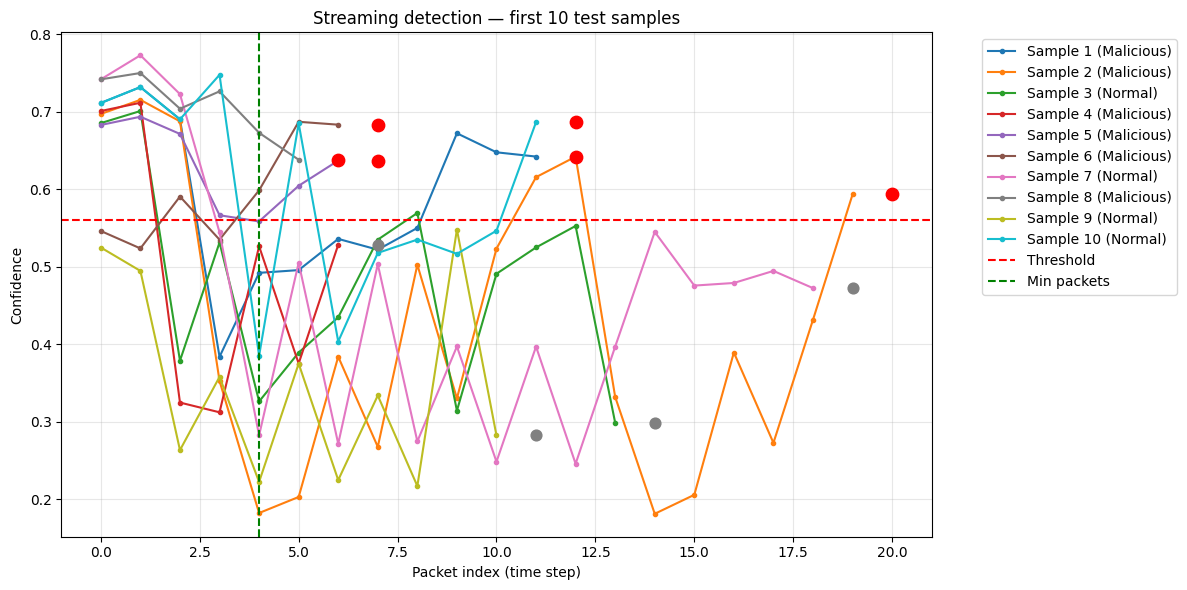


Idx |     Label |  Triggered |  Step
-----------------------------------
  0 | Malicious |        Yes |    12
  1 | Malicious |        Yes |    20
  2 |    Normal |         No |     -
  3 | Malicious |         No |     -
  4 | Malicious |        Yes |     7
  5 | Malicious |        Yes |     7
  6 |    Normal |         No |     -
  7 | Malicious |        Yes |     6
  8 |    Normal |         No |     -
  9 |    Normal |        Yes |    12

--- Summary ---
Flux CnC détectés: 5/6
Flux légitimes tués (Oops): 1/4
Precision: 0.833, Recall: 0.833, F1: 0.833


In [13]:
# Appel de notre fonction
results = evaluate_and_plot(
    model,
    X_test_tensor,
    y_test_tensor,
    threshold=0.56,
    min_packets=4,
    required_over_threshold=3,
    consecutive=False,
    max_samples=10,
    pad_token=PAD_TOKEN,
    plot=True
)

In [16]:
# Code pour convertir le model en TorchScript
# Necessaire pour l'inclure dans un programme utilisant LibTorch (C/C++)

weights = torch.load("/content/drive/MyDrive/CnC_RNN/rnn_gru_detection_cnc.pth", map_location=device)
model = RNNModel(len(int_of_letters)+1).to(device)
model.load_state_dict(weights)
model.eval()

# Pour convertir le model en torchscript, il faut "tracer" le flow de la forward-pass
# Pour cela il faut suivre le chemin parcouru par une entree (qui peut etre aleatoire, cela n'a pas d'importance)
signal = torch.randint(0, len(int_of_letters)+1, (1, 10))
traced = torch.jit.trace(model, signal)
traced.save("/content/drive/MyDrive/CnC_RNN/rnn_trace.pt")